# 케라스 창시자에게 배우는 딥러닝을 참고하여 만든 자료입니다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 설명

- 수년에 걸쳐 10분마다 (기온, 기압, 습도, 풍향 등)의 14개의 관측치를 기록한 데이터
- 2009 ~ 2016 사이의 데이터
- 최근 몇 일간의 데이터를 입력으로 사용하여 24시간 이후의 기온을 예측하는 모델을 만들자

In [2]:
# download the jena-climate data
# https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
fname = '/content/drive/MyDrive/keras/딥러닝 실습을 위한 케라스 기초/datasets/jena_climate_2009_2016/jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### 데이터 파싱하기

In [11]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values
    

In [12]:
float_data.shape

(420551, 14)

In [13]:
print(float_data[0])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


### 온도 그래프 그리기

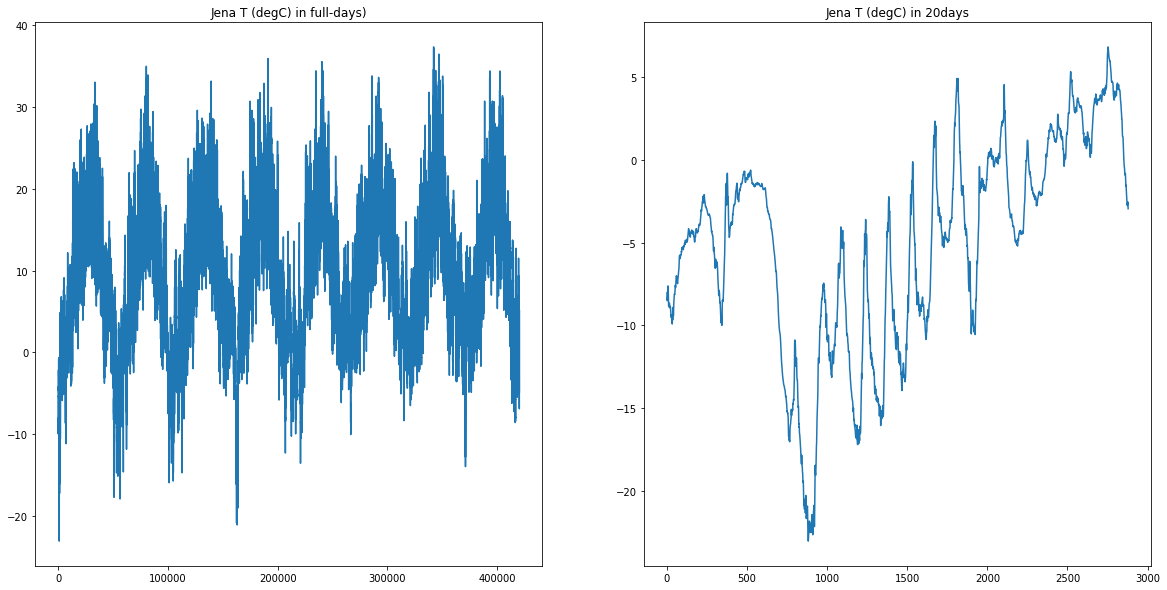

In [14]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # T (degC)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("Jena T (degC) in full-days)")
plt.plot(range(len(temp)), temp)

plt.subplot(122)
plt.title("Jena T (degC) in 20days")
plt.plot(range(144*20), temp[:144*20])

plt.show()

### Normalize

In [15]:
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)

float_data = (float_data - mean) / std

### Data Generator

In [16]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### Train, Validation, Test Generator

In [17]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [18]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905488


In [19]:
0.29 * std[1]

2.5672247338393377

In [20]:
def plot_model(history, title):
    plt.figure(figsize=(10,5))
    ## loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')

    # Accuracy
    plt.subplot(122)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title(title)
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')


    plt.show()

### Build MLP

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics= ['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
500/500 [==============================] - 11s 23ms/step - loss: 1.4613 - mean_absolute_error: 1.4613 - val_loss: 0.7200 - val_mean_absolute_error: 0.7200
Epoch 2/5
500/500 [==============================] - 11s 23ms/step - loss: 0.5612 - mean_absolute_error: 0.5612 - val_loss: 0.4186 - val_mean_absolute_error: 0.4186
Epoch 3/5
500/500 [==============================] - 11s 22ms/step - loss: 0.3226 - mean_absolute_error: 0.3226 - val_loss: 0.3493 - val_mean_absolute_error: 0.3493
Epoch 4/5
500/500 [==============================] - 11s 22ms/step - loss: 0.2705 - mean_absolute_error: 0.2705 - val_loss: 0.2996 - val_mean_absolute_error: 0.2996
Epoch 5/5
500/500 [==============================] - 11s 22ms/step - loss: 0.2563 - mean_absolute_error: 0.2563 - val_loss: 0.3090 - val_mean_absolute_error: 0.3090


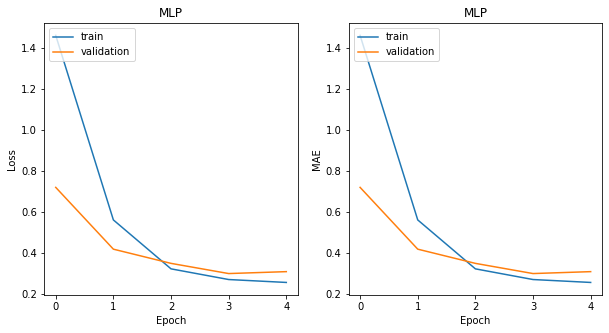

In [23]:
title = "MLP"
plot_model(history, title)

In [33]:
result = dict()

loss, mae = model.evaluate_generator(test_gen, test_steps)
print("The loss of {} is \t{:02.5f}".format(title, loss))
print("The mae of {} is {:02.5f}".format(title, mae))
result['MLP'] = [loss, mae]

The loss of MLP is 	0.28717
The mae of MLP is 0.28717


### Build GRU

In [25]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics= ['mean_absolute_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 368s 735ms/step - loss: 0.3205 - mean_absolute_error: 0.3205 - val_loss: 0.2822 - val_mean_absolute_error: 0.2822
Epoch 2/5
500/500 [==============================] - 368s 735ms/step - loss: 0.3076 - mean_absolute_error: 0.3076 - val_loss: 0.2797 - val_mean_absolute_error: 0.2797
Epoch 3/5
500/500 [==============================] - 369s 737ms/step - loss: 0.2991 - mean_absolute_error: 0.2991 - val_loss: 0.2707 - val_mean_absolute_error: 0.2707
Epoch 4/5
500/500 [==============================] - 378s 757ms/step - loss: 0.2938 - mean_absolute_error: 0.2938 - val_loss: 0.2656 - val_mean_absolute_error: 0.2656
Epoch 5/5
500/500 [==============================] - 367s 733ms/step - loss: 0.2889 - mean_absolute_error: 0.2889 - val_loss: 0.2651 - val_mean_absolute_error: 0.2651


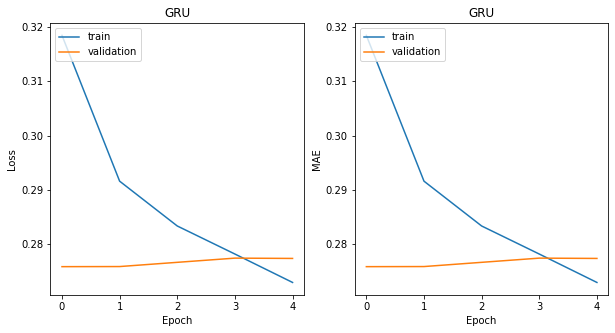

In [34]:
title = "GRU"
plot_model(history, title)

In [28]:
loss, mae = model.evaluate_generator(test_gen, test_steps)
print("The loss of {} is \t{:02.5f}".format(title, loss))
print("The mae of {} is {:02.5f}".format(title, mae))
result['GRU'] = [loss, mae]

The loss of MLP is 	0.28402
The accuracy of MLP is 0.28402


### LSTM

In [29]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics= ['mean_absolute_error'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6016      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 427s 854ms/step - loss: 0.3184 - mean_absolute_error: 0.3184 - val_loss: 0.2759 - val_mean_absolute_error: 0.2759
Epoch 2/5
500/500 [==============================] - 435s 870ms/step - loss: 0.2916 - mean_absolute_error: 0.2916 - val_loss: 0.2759 - val_mean_absolute_error: 0.2759
Epoch 3/5
500/500 [==============================] - 431s 861ms/step - loss: 0.2834 - mean_absolute_error: 0.2834 - val_loss: 0.2767 - val_mean_absolute_error: 0.2767
Epoch 4/5
500/500 [==============================] - 425s 850ms/step - loss: 0.2782 - mean_absolute_error: 0.2782 - val_loss: 0.2774 - val_mean_absolute_error: 0.2774
Epoch 5/5
500/500 [==============================] - 421s 843ms/step - loss: 0.2730 - mean_absolute_error: 0.2730 - val_loss: 0.2774 - val_mean_absolute_error: 0.2774


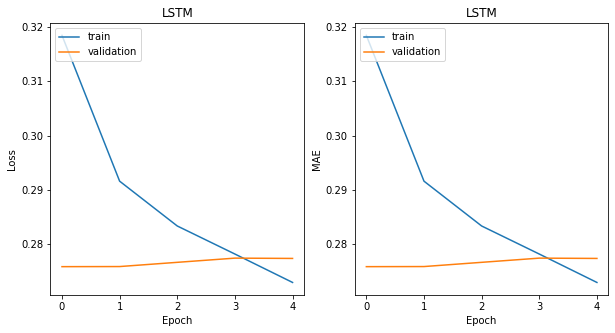

In [35]:
title = "LSTM"
plot_model(history, title)

In [32]:
loss, mae = model.evaluate_generator(test_gen, test_steps)
print("The loss of {} is \t{:02.5f}".format(title, loss))
print("The accuracy of {} is {:02.5f}".format(title, mae))
result['LSTM'] = [loss, mae]

The loss of MLP is 	0.28734
The accuracy of MLP is 0.28734
